In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
import gc
import joblib
import re
from collections import Counter
from tqdm import tqdm

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, confusion_matrix, roc_auc_score,
                           roc_curve, classification_report,
                           precision_recall_curve, average_precision_score)
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Embedding, Dense, Dropout,
                                   LayerNormalization, MultiHeadAttention,
                                   GlobalAveragePooling1D, Add, Concatenate,
                                   GlobalMaxPooling1D)
from tensorflow.keras.callbacks import (EarlyStopping, ReduceLROnPlateau,
                                      ModelCheckpoint, TensorBoard)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K

In [2]:
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
np.random.seed(42)
tf.random.set_seed(42)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [3]:
df = pd.read_csv('csic_database.csv')
df.head()

,Unnamed: 0,Method,User-Agent,Pragma,Cache-Control,Accept,Accept-encoding,Accept-charset,language,host,cookie,content-type,connection,lenght,content,classification,URL
0,Normal,GET,Mozilla/5.0 (compatible; Konqueror/3.5; Linux) KHTML/3.5.8 (like Gecko),no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml,text/html;q=0.9,text/plain;q=0.8,image/png,*/*;q=0.5","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=1F767F17239C9B670A39E9B10C3825F4,NaN,close,NaN,NaN,0,http://localhost:8080/tienda1/index.jsp HTTP/1.1
1,Normal,GET,Mozilla/5.0 (compatible; Konqueror/3.5; Linux) KHTML/3.5.8 (like Gecko),no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml,text/html;q=0.9,text/plain;q=0.8,image/png,*/*;q=0.5","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=81761ACA043B0E6014CA42A4BCD06AB5,NaN,close,NaN,NaN,0,http://localhost:8080/tienda1/publico/anadir.jsp?id=3&nombre=Vino+Rioja&precio=100&cantidad=55&B...
2,Normal,POST,Mozilla/5.0 (compatible; Konqueror/3.5; Linux) KHTML/3.5.8 (like Gecko),no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml,text/html;q=0.9,text/plain;q=0.8,image/png,*/*;q=0.5","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=933185092E0B668B90676E0A2B0767AF,application/x-www-form-urlencoded,Connection: close,Content-Length: 68,id=3&nombre=Vino+Rioja&precio=100&cantidad=55&B1=A%F1adir+al+carrito,0,http://localhost:8080/tienda1/publico/anadir.jsp HTTP/1.1
3,Normal,GET,Mozilla/5.0 (compatible; Konqueror/3.5; Linux) KHTML/3.5.8 (like Gecko),no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml,text/html;q=0.9,text/plain;q=0.8,image/png,*/*;q=0.5","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=8FA18BA82C5336D03D3A8AFA3E68CBB0,NaN,close,NaN,NaN,0,http://localhost:8080/tienda1/publico/autenticar.jsp?modo=entrar&login=choong&pwd=d1se3ci%F3n&re...
4,Normal,POST,Mozilla/5.0 (compatible; Konqueror/3.5; Linux) KHTML/3.5.8 (like Gecko),no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml,text/html;q=0.9,text/plain;q=0.8,image/png,*/*;q=0.5","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=7104E6C68A6BCF1423DAE990CE49FEE2,application/x-www-form-urlencoded,Connection: close,Content-Length: 63,modo=entrar&login=choong&pwd=d1se3ci%F3n&remember=off&B1=Entrar,0,http://localhost:8080/tienda1/publico/autenticar.jsp HTTP/1.1


In [4]:
print(f"\nDataset Shape: {df.shape}")
print(f"\nColumn Names:\n{df.columns.tolist()}")


Dataset Shape: (61065, 17)

Column Names:
['Unnamed: 0', 'Method', 'User-Agent', 'Pragma', 'Cache-Control', 'Accept', 'Accept-encoding', 'Accept-charset', 'language', 'host', 'cookie', 'content-type', 'connection', 'lenght', 'content', 'classification', 'URL']


In [5]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61065 entries, 0 to 61064
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Unnamed: 0       61065 non-null  object
 1   Method           61065 non-null  object
 2   User-Agent       61065 non-null  object
 3   Pragma           61065 non-null  object
 4   Cache-Control    61065 non-null  object
 5   Accept           60668 non-null  object
 6   Accept-encoding  61065 non-null  object
 7   Accept-charset   61065 non-null  object
 8   language         61065 non-null  object
 9   host             61065 non-null  object
 10  cookie           61065 non-null  object
 11  content-type     17977 non-null  object
 12  connection       61065 non-null  object
 13  lenght           17977 non-null  object
 14  content          17977 non-null  object
 15  classification   61065 non-null  int64 
 16  URL              61065 non-null  object
dtypes: int64(1), object(16)
memory 

,classification
count,61065.0000
mean,0.4105
std,0.4919
min,0.0000
25%,0.0000
50%,0.0000
75%,1.0000
max,1.0000


In [6]:
print(df['classification'].value_counts())
print(df['classification'].value_counts(normalize=True) * 100)

classification
0    36000
1    25065
Name: count, dtype: int64
classification
0   58.9536
1   41.0464
Name: proportion, dtype: float64


In [7]:
df.isnull().sum()

,0
Unnamed: 0,0
Method,0
User-Agent,0
Pragma,0
Cache-Control,0
Accept,397
Accept-encoding,0
Accept-charset,0
language,0
host,0


In [8]:
print("\nNormal Requests (first 3):")
print(df[df['classification'] == 0][['Method', 'URL', 'classification']].head())
print("\nAttack Requests (first 3):")
print(df[df['classification'] == 1][['Method', 'URL', 'classification']].head())


Normal Requests (first 3):
  Method  \
0    GET   
1    GET   
2   POST   
3    GET   
4   POST   

                                                                                                   URL  \
0                                                     http://localhost:8080/tienda1/index.jsp HTTP/1.1   
1  http://localhost:8080/tienda1/publico/anadir.jsp?id=3&nombre=Vino+Rioja&precio=100&cantidad=55&B...   
2                                            http://localhost:8080/tienda1/publico/anadir.jsp HTTP/1.1   
3  http://localhost:8080/tienda1/publico/autenticar.jsp?modo=entrar&login=choong&pwd=d1se3ci%F3n&re...   
4                                        http://localhost:8080/tienda1/publico/autenticar.jsp HTTP/1.1   

   classification  
0               0  
1               0  
2               0  
3               0  
4               0  

Attack Requests (first 3):
      Method  \
36000    GET   
36001   POST   
36002    GET   
36003   POST   
36004    GET   

                 

In [9]:
def clean_text(text):
    if pd.isna(text):
        return ""

    text = str(text)
    text = text.lower()
    text = re.sub(r'http[s]?://', '', text)
    text = re.sub(r'localhost:\d+', 'localhost', text)
    text = re.sub(r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}', 'ipaddress', text)
    text = re.sub(r'[a-f0-9]{32}', 'sessionid', text)
    text = re.sub(r'jsessionid=[a-f0-9]+', 'jsessionid=sessionid', text)
    text = re.sub(r'%[0-9a-f]{2}', ' hex ', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()

    return text

def create_combined_text(row):
    parts = []

    if pd.notna(row['Method']):
        parts.append(str(row['Method']))

    if pd.notna(row['URL']):
        parts.append(str(row['URL']))

    if pd.notna(row['content']):
        parts.append(str(row['content']))

    combined = ' '.join(parts)
    return clean_text(combined)

In [10]:
df['combined_text'] = df.apply(create_combined_text, axis=1)

print("\nNormal Request:")
print(df[df['classification'] == 0]['combined_text'].iloc[0][:200])
print("\nAttack Request:")
print(df[df['classification'] == 1]['combined_text'].iloc[0][:200])

print(f"\nText Length Statistics:")
df['text_length'] = df['combined_text'].str.len()
print(df['text_length'].describe())


Normal Request:
get localhost/tienda1/index.jsp http/1.1

Attack Request:
get localhost/tienda1/publico/anadir.jsp?id=2&nombre=jam hex n+ib hex rico&precio=85&cantidad= hex hex +drop+table+usuarios hex +select+*+from+datos+where+nombre+like+ hex hex &b1=a hex adir+al+carrit

Text Length Statistics:
count   61065.0000
mean      118.3335
std       104.9666
min        23.0000
25%        50.0000
50%        69.0000
75%       125.0000
max      1115.0000
Name: text_length, dtype: float64


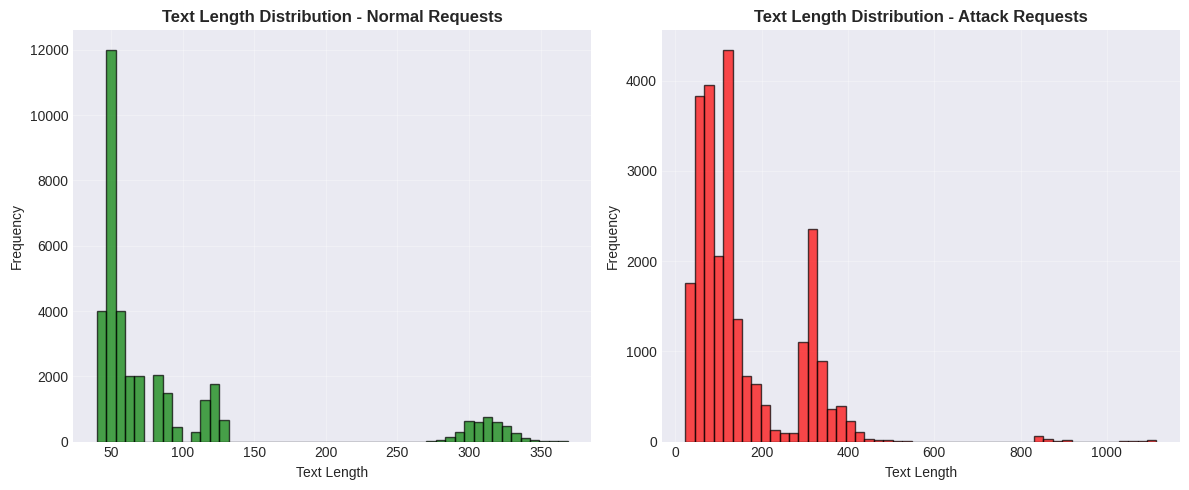

In [11]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
df[df['classification'] == 0]['text_length'].hist(bins=50, alpha=0.7, color='green', edgecolor='black')
plt.title('Text Length Distribution - Normal Requests', fontsize=12, fontweight='bold')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
df[df['classification'] == 1]['text_length'].hist(bins=50, alpha=0.7, color='red', edgecolor='black')
plt.title('Text Length Distribution - Attack Requests', fontsize=12, fontweight='bold')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

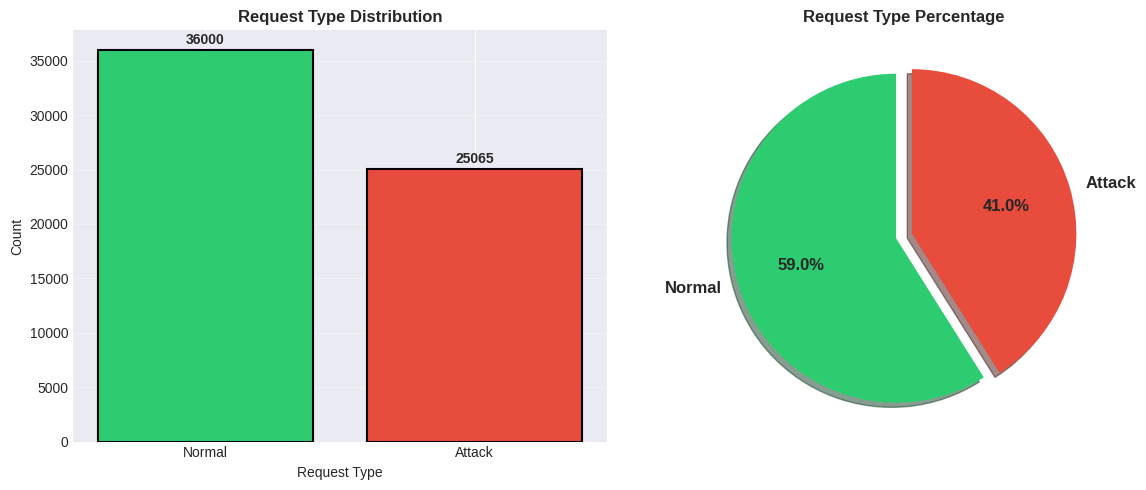

In [12]:
class_counts = df['classification'].value_counts()
class_labels = ['Normal', 'Attack']
colors = ['#2ecc71', '#e74c3c']

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(class_labels, class_counts.values, color=colors, edgecolor='black', linewidth=1.5)
plt.title('Request Type Distribution', fontsize=12, fontweight='bold')
plt.xlabel('Request Type')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.3)
for i, v in enumerate(class_counts.values):
    plt.text(i, v + 500, str(v), ha='center', fontweight='bold')

plt.subplot(1, 2, 2)
plt.pie(class_counts.values, labels=class_labels, colors=colors, autopct='%1.1f%%',
        startangle=90, explode=(0.05, 0.05), shadow=True, textprops={'fontsize': 12, 'fontweight': 'bold'})
plt.title('Request Type Percentage', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

In [13]:
method_dist = df.groupby(['classification', 'Method']).size().unstack(fill_value=0)
print("\nMethod Distribution by Class:")
print(method_dist)


Method Distribution by Class:
Method            GET  POST  PUT
classification                  
0               28000  8000    0
1               15088  9580  397


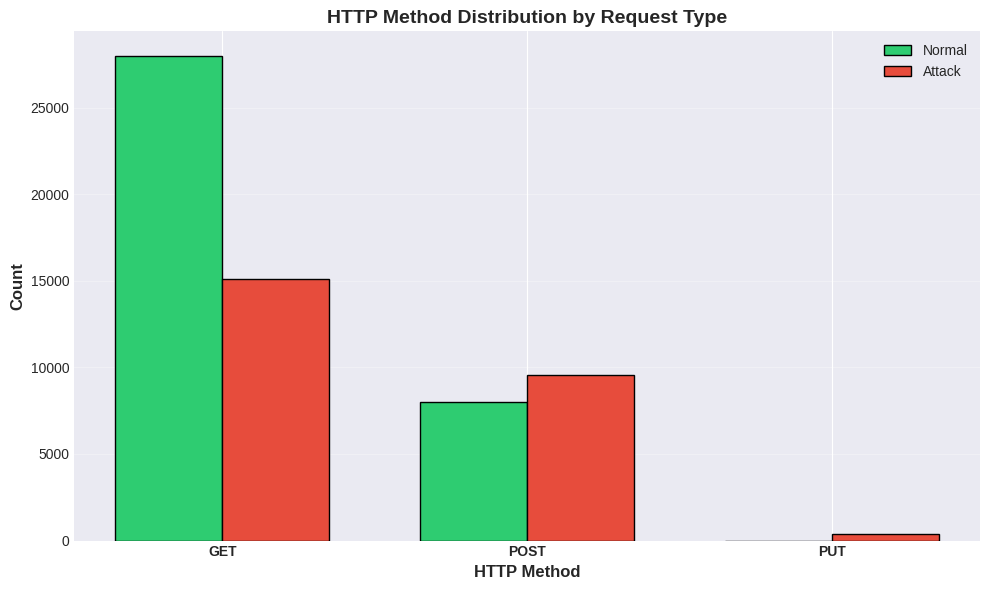

In [14]:
plt.figure(figsize=(10, 6))
x = np.arange(len(method_dist.columns))
width = 0.35

plt.bar(x - width/2, method_dist.loc[0], width, label='Normal', color='#2ecc71', edgecolor='black')
plt.bar(x + width/2, method_dist.loc[1], width, label='Attack', color='#e74c3c', edgecolor='black')

plt.xlabel('HTTP Method', fontsize=12, fontweight='bold')
plt.ylabel('Count', fontsize=12, fontweight='bold')
plt.title('HTTP Method Distribution by Request Type', fontsize=14, fontweight='bold')
plt.xticks(x, method_dist.columns, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [15]:
attack_keywords = ['select', 'union', 'drop', 'insert', 'delete', 'update',
                   'script', 'alert', 'exec', 'xp_', 'sp_', 'or', 'and',
                   '--', '/*', '*/', 'char', 'cast', 'convert']

def count_keywords(text):
    text_lower = text.lower()
    return sum(1 for keyword in attack_keywords if keyword in text_lower)

df['keyword_count'] = df['combined_text'].apply(count_keywords)

print("\nKeyword Count Statistics by Class:")
print(df.groupby('classification')['keyword_count'].describe())


Keyword Count Statistics by Class:
                    count   mean    std    min    25%    50%    75%    max
classification                                                            
0              36000.0000 0.3103 0.5667 0.0000 0.0000 0.0000 1.0000 3.0000
1              25065.0000 0.8023 0.9358 0.0000 0.0000 1.0000 1.0000 5.0000


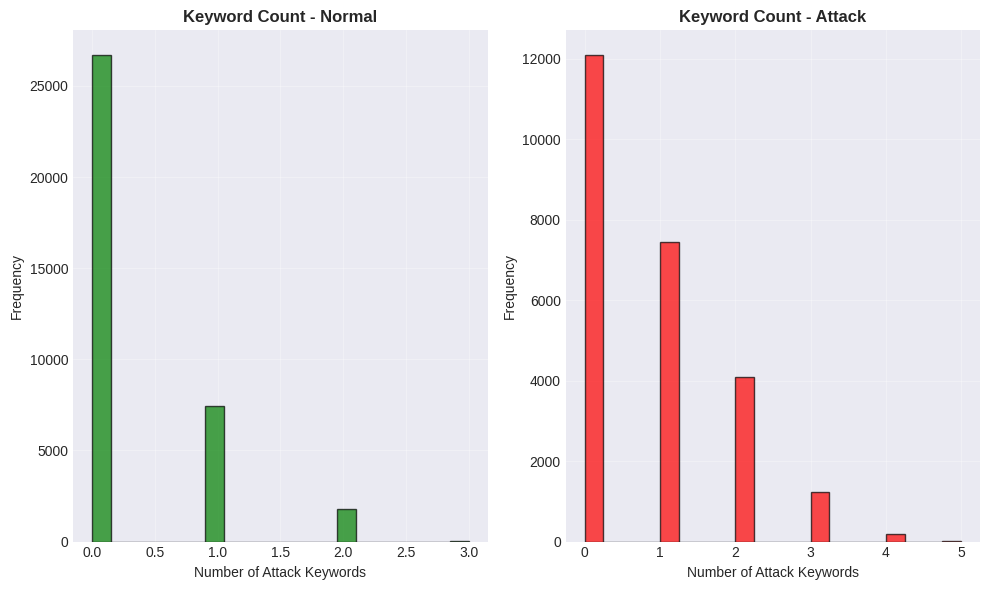

In [16]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
df[df['classification'] == 0]['keyword_count'].hist(bins=20, alpha=0.7, color='green', edgecolor='black')
plt.title('Keyword Count - Normal', fontsize=12, fontweight='bold')
plt.xlabel('Number of Attack Keywords')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
df[df['classification'] == 1]['keyword_count'].hist(bins=20, alpha=0.7, color='red', edgecolor='black')
plt.title('Keyword Count - Attack', fontsize=12, fontweight='bold')
plt.xlabel('Number of Attack Keywords')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [17]:
X = df['combined_text'].values
y = df['classification'].values

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1765, random_state=42, stratify=y_temp
)

print(f"Total Dataset Size: {len(X)}")
print(f"Training Set Size: {len(X_train)} ({len(X_train)/len(X)*100:.2f}%)")
print(f"Validation Set Size: {len(X_val)} ({len(X_val)/len(X)*100:.2f}%)")
print(f"Test Set Size: {len(X_test)} ({len(X_test)/len(X)*100:.2f}%)")

print(f"\nTraining Set Distribution:")
print(f"Normal: {np.sum(y_train == 0)} ({np.sum(y_train == 0)/len(y_train)*100:.2f}%)")
print(f"Attack: {np.sum(y_train == 1)} ({np.sum(y_train == 1)/len(y_train)*100:.2f}%)")

print(f"\nValidation Set Distribution:")
print(f"Normal: {np.sum(y_val == 0)} ({np.sum(y_val == 0)/len(y_val)*100:.2f}%)")
print(f"Attack: {np.sum(y_val == 1)} ({np.sum(y_val == 1)/len(y_val)*100:.2f}%)")

print(f"\nTest Set Distribution:")
print(f"Normal: {np.sum(y_test == 0)} ({np.sum(y_test == 0)/len(y_test)*100:.2f}%)")
print(f"Attack: {np.sum(y_test == 1)} ({np.sum(y_test == 1)/len(y_test)*100:.2f}%)")

Total Dataset Size: 61065
Training Set Size: 42743 (70.00%)
Validation Set Size: 9162 (15.00%)
Test Set Size: 9160 (15.00%)

Training Set Distribution:
Normal: 25199 (58.95%)
Attack: 17544 (41.05%)

Validation Set Distribution:
Normal: 5401 (58.95%)
Attack: 3761 (41.05%)

Test Set Distribution:
Normal: 5400 (58.95%)
Attack: 3760 (41.05%)


In [18]:
MAX_WORDS = 10000
MAX_LEN = 200

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>', lower=True)
tokenizer.fit_on_texts(X_train)

vocab_size = min(len(tokenizer.word_index) + 1, MAX_WORDS)

print(f"Vocabulary Size: {vocab_size}")
print(f"Maximum Sequence Length: {MAX_LEN}")
print(f"Total Unique Words in Training: {len(tokenizer.word_index)}")

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post', truncating='post')

print(f"\nTraining Sequences Shape: {X_train_pad.shape}")
print(f"Validation Sequences Shape: {X_val_pad.shape}")
print(f"Test Sequences Shape: {X_test_pad.shape}")

print("\nSample Tokenized 20 tokens:")
print(X_train_pad[0][:20])

joblib.dump(tokenizer, 'tokenizer.pkl')

Vocabulary Size: 10000
Maximum Sequence Length: 200
Total Unique Words in Training: 32037

Training Sequences Shape: (42743, 200)
Validation Sequences Shape: (9162, 200)
Test Sequences Shape: (9160, 200)

Sample Tokenized 20 tokens:
[  8   5   6  17  18 108  50 116   4   2   2   0   0   0   0   0   0   0
   0   0]


['tokenizer.pkl']

In [19]:
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights = {i: weight for i, weight in enumerate(class_weights_array)}

print(f"Class Weights:")
print(f"  Class 0 (Normal): {class_weights[0]:.4f}")
print(f"  Class 1 (Attack): {class_weights[1]:.4f}")

Class Weights:
  Class 0 (Normal): 0.8481
  Class 1 (Attack): 1.2182


In [20]:
class TokenAndPositionEmbedding(keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim, **kwargs):
        super(TokenAndPositionEmbedding, self).__init__(**kwargs)
        self.maxlen = maxlen
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.token_emb = Embedding(
            input_dim=vocab_size,
            output_dim=embed_dim,
            embeddings_regularizer=l2(1e-5)
        )
        self.pos_emb = Embedding(
            input_dim=maxlen,
            output_dim=embed_dim,
            embeddings_regularizer=l2(1e-5)
        )

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

    def get_config(self):
        config = super().get_config()
        config.update({
            'maxlen': self.maxlen,
            'vocab_size': self.vocab_size,
            'embed_dim': self.embed_dim
        })
        return config

In [21]:
class TransformerBlock(keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout_rate=0.1, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.dropout_rate = dropout_rate

        self.att = MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embed_dim,
            dropout=dropout_rate
        )
        self.ffn = keras.Sequential([
            Dense(ff_dim, activation='relu', kernel_regularizer=l2(1e-5)),
            Dropout(dropout_rate),
            Dense(embed_dim, kernel_regularizer=l2(1e-5))
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(dropout_rate)
        self.dropout2 = Dropout(dropout_rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs, training=training)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)

        ffn_output = self.ffn(out1, training=training)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2

    def get_config(self):
        config = super().get_config()
        config.update({
            'embed_dim': self.embed_dim,
            'num_heads': self.num_heads,
            'ff_dim': self.ff_dim,
            'dropout_rate': self.dropout_rate
        })
        return config

In [22]:
def f1_metric(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(tf.round(y_pred), tf.float32)

    tp = K.sum(y_true * y_pred)
    fp = K.sum((1 - y_true) * y_pred)
    fn = K.sum(y_true * (1 - y_pred))

    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())

    f1 = 2 * precision * recall / (precision + recall + K.epsilon())
    return f1

def balanced_accuracy(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(tf.round(y_pred), tf.float32)

    tp = K.sum(y_true * y_pred)
    tn = K.sum((1 - y_true) * (1 - y_pred))
    fp = K.sum((1 - y_true) * y_pred)
    fn = K.sum(y_true * (1 - y_pred))

    total_positives = tp + fn
    total_negatives = tn + fp

    sensitivity = tp / (total_positives + K.epsilon())
    specificity = tn / (total_negatives + K.epsilon())

    return (sensitivity + specificity) / 2.0


In [23]:
EMBED_DIM = 128
NUM_HEADS = 8
FF_DIM = 512
DROPOUT_RATE = 0.3
NUM_TRANSFORMER_BLOCKS = 3

inputs = Input(shape=(MAX_LEN,))

embedding_layer = TokenAndPositionEmbedding(MAX_LEN, vocab_size, EMBED_DIM)
x = embedding_layer(inputs)

for _ in range(NUM_TRANSFORMER_BLOCKS):
    x = TransformerBlock(EMBED_DIM, NUM_HEADS, FF_DIM, DROPOUT_RATE)(x)

avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
concat = Concatenate()([avg_pool, max_pool])

x = Dense(256, activation='relu', kernel_regularizer=l2(1e-4))(concat)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(1e-4))(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(1e-4))(x)
x = Dropout(0.2)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_and_position… │ (None, 200, 128)  │  1,305,600 │ input_layer[0][0] │
│ (TokenAndPositionE… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_block   │ (None, 200, 128)  │    659,712 │ token_and_positi… │
│ (TransformerBlock)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_block_1 │ (None, 200, 128)  │    659,712 │ transformer_bloc… │
│ (TransformerBlock)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_block_2 │ (None, 200, 128)  │    659,712 │ transformer_bloc… │
│ (TransformerBlock)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ transformer_bloc… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ transformer_bloc… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 256)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 256)       │     65,792 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 256)       │          0 │ dense_6[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 128)       │     32,896 │ dropout_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 128)       │          0 │ dense_7[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 64)        │      8,256 │ dropout_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 64)        │          0 │ dense_8[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 1)         │         65 │ dropout_14[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,391,745 (12.94 MB)

 Trainable params: 3,391,745 (12.94 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
LEARNING_RATE = 1e-4

optimizer = Adam(learning_rate=LEARNING_RATE)

model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc'),
        f1_metric,
        balanced_accuracy
    ]
)

In [25]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1,
    mode='min'
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1,
    mode='min'
)

model_checkpoint = ModelCheckpoint(
    'best_csic_transformer_model.keras',
    monitor='val_f1_metric',
    save_best_only=True,
    mode='max',
    verbose=1
)

callbacks_list = [early_stopping, reduce_lr, model_checkpoint]

In [26]:
BATCH_SIZE = 128
EPOCHS = 50

history = model.fit(
    X_train_pad,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val_pad, y_val),
    callbacks=callbacks_list,
    class_weight=class_weights,
    verbose=1
)


Epoch 1/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.5776 - auc: 0.6119 - balanced_accuracy: 0.5000 - f1_metric: 0.4379 - loss: 0.7442 - precision: 0.4906 - recall: 0.5722
Epoch 1: val_f1_metric improved from -inf to 0.38377, saving model to best_csic_transformer_model.keras
334/334 ━━━━━━━━━━━━━━━━━━━━ 124s 292ms/step - accuracy: 0.5779 - auc: 0.6125 - balanced_accuracy: 0.5000 - f1_metric: 0.4378 - loss: 0.7438 - precision: 0.4910 - recall: 0.5726 - val_accuracy: 0.9296 - val_auc: 0.9833 - val_balanced_accuracy: 0.5000 - val_f1_metric: 0.3838 - val_loss: 0.2344 - val_precision: 0.9730 - val_recall: 0.8522 - learning_rate: 1.0000e-04
Epoch 2/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9553 - auc: 0.9836 - balanced_accuracy: 0.5000 - f1_metric: 0.4078 - loss: 0.2022 - precision: 0.9528 - recall: 0.9377
Epoch 2: val_f1_metric improved from 0.38377 to 0.39930, saving model to best_csic_transformer_model.keras
334/334 ━━━━━━━━━━━━━━━━━━━━ 82s 246ms/step - ac

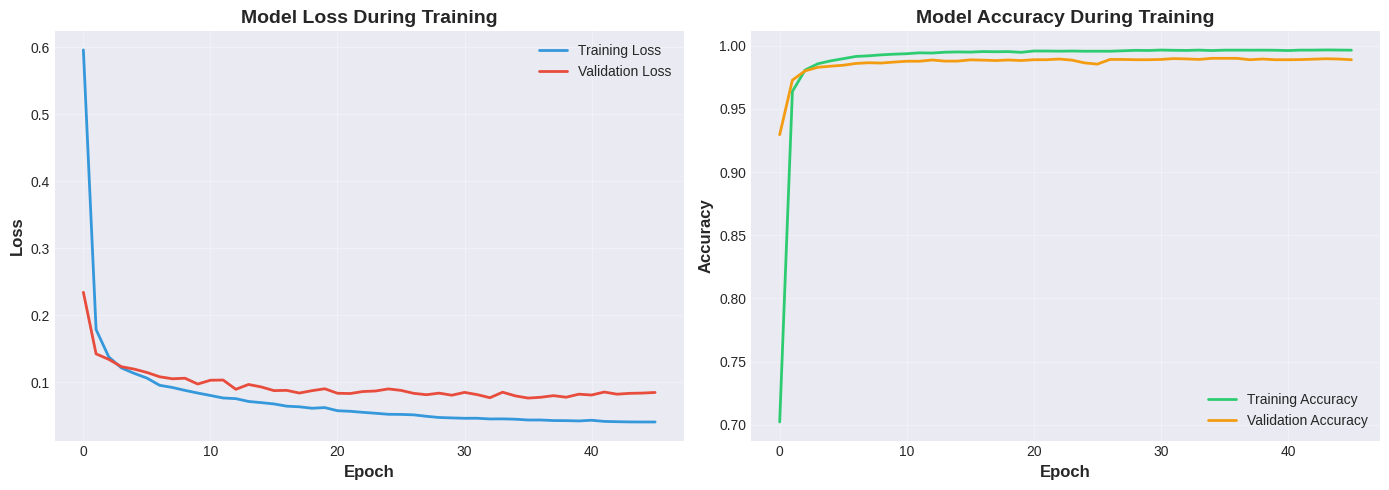

In [28]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', linewidth=2, color='#3498db')
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2, color='#e74c3c')
plt.title('Model Loss During Training', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12, fontweight='bold')
plt.ylabel('Loss', fontsize=12, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2, color='#2ecc71')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2, color='#f39c12')
plt.title('Model Accuracy During Training', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12, fontweight='bold')
plt.ylabel('Accuracy', fontsize=12, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

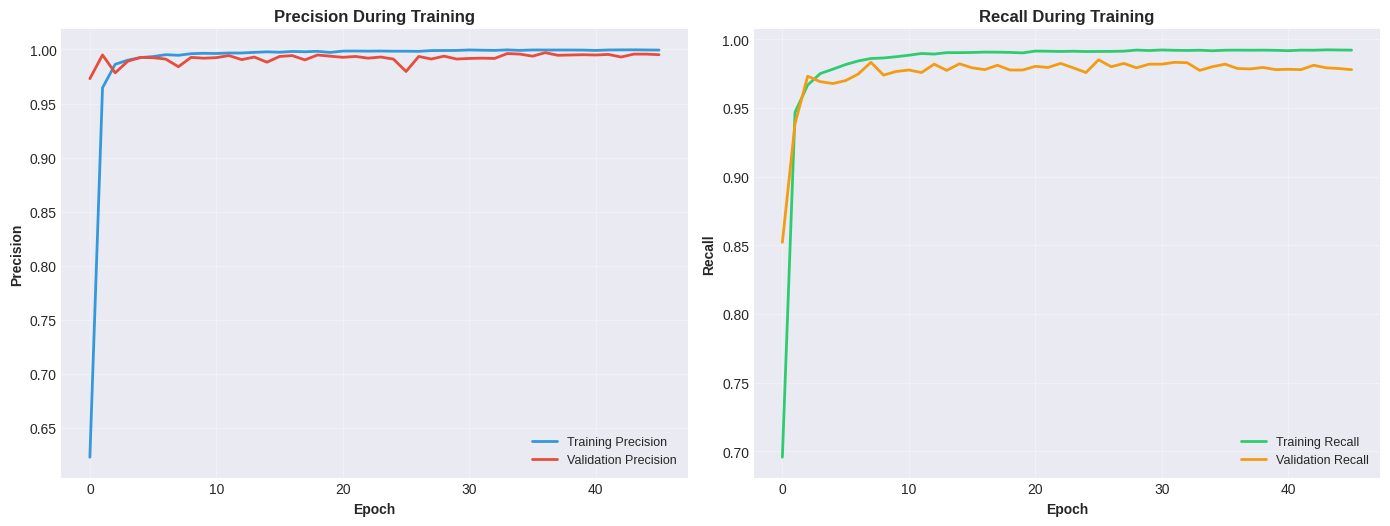

In [41]:
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.plot(history.history['precision'], label='Training Precision', linewidth=2, color='#3498db')
plt.plot(history.history['val_precision'], label='Validation Precision', linewidth=2, color='#e74c3c')
plt.title('Precision During Training', fontsize=12, fontweight='bold')
plt.xlabel('Epoch', fontsize=10, fontweight='bold')
plt.ylabel('Precision', fontsize=10, fontweight='bold')
plt.legend(fontsize=9)
plt.grid(alpha=0.3)

plt.subplot(2, 2, 2)
plt.plot(history.history['recall'], label='Training Recall', linewidth=2, color='#2ecc71')
plt.plot(history.history['val_recall'], label='Validation Recall', linewidth=2, color='#f39c12')
plt.title('Recall During Training', fontsize=12, fontweight='bold')
plt.xlabel('Epoch', fontsize=10, fontweight='bold')
plt.ylabel('Recall', fontsize=10, fontweight='bold')
plt.legend(fontsize=9)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [30]:
best_model = tf.keras.models.load_model(
    'best_csic_transformer_model.keras',
    custom_objects={
        'TransformerBlock': TransformerBlock,
        'TokenAndPositionEmbedding': TokenAndPositionEmbedding,
        'f1_metric': f1_metric,
        'balanced_accuracy': balanced_accuracy
    }
)

val_predictions_proba = best_model.predict(X_val_pad, batch_size=256, verbose=1)
val_predictions = (val_predictions_proba >= 0.5).astype(int).flatten()

val_accuracy = accuracy_score(y_val, val_predictions)
val_precision = precision_score(y_val, val_predictions, zero_division=0)
val_recall = recall_score(y_val, val_predictions, zero_division=0)
val_f1 = f1_score(y_val, val_predictions, zero_division=0)
val_roc_auc = roc_auc_score(y_val, val_predictions_proba)

tn, fp, fn, tp = confusion_matrix(y_val, val_predictions).ravel()
val_specificity = tn / (tn + fp)
val_sensitivity = tp / (tp + fn)
val_balanced_acc = (val_sensitivity + val_specificity) / 2.0

print("VALIDATION SET PERFORMANCE (THRESHOLD = 0.5)")
print(f"Accuracy:          {val_accuracy:.4f}")
print(f"Precision:         {val_precision:.4f}")
print(f"Recall:            {val_recall:.4f}")
print(f"F1 Score:          {val_f1:.4f}")
print(f"ROC-AUC:           {val_roc_auc:.4f}")
print(f"Specificity:       {val_specificity:.4f}")
print(f"Sensitivity:       {val_sensitivity:.4f}")
print(f"Balanced Accuracy: {val_balanced_acc:.4f}")

print(f"True Negatives:  {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives:  {tp}")

36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 235ms/step
VALIDATION SET PERFORMANCE (THRESHOLD = 0.5)
Accuracy:          0.9855
Precision:         0.9796
Recall:            0.9851
F1 Score:          0.9824
ROC-AUC:           0.9942
Specificity:       0.9857
Sensitivity:       0.9851
Balanced Accuracy: 0.9854
True Negatives:  5324
False Positives: 77
False Negatives: 56
True Positives:  3705


In [31]:
precision_vals, recall_vals, thresholds = precision_recall_curve(y_val, val_predictions_proba)
f1_scores = 2 * (precision_vals * recall_vals) / (precision_vals + recall_vals + 1e-10)

optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx] if optimal_idx < len(thresholds) else 0.5

print(f"Optimal Threshold: {optimal_threshold:.4f}")
print(f"Best F1 Score at Optimal Threshold: {f1_scores[optimal_idx]:.4f}")

val_predictions_optimal = (val_predictions_proba >= optimal_threshold).astype(int).flatten()

val_accuracy_opt = accuracy_score(y_val, val_predictions_optimal)
val_precision_opt = precision_score(y_val, val_predictions_optimal, zero_division=0)
val_recall_opt = recall_score(y_val, val_predictions_optimal, zero_division=0)
val_f1_opt = f1_score(y_val, val_predictions_optimal, zero_division=0)

tn_opt, fp_opt, fn_opt, tp_opt = confusion_matrix(y_val, val_predictions_optimal).ravel()
val_specificity_opt = tn_opt / (tn_opt + fp_opt)
val_sensitivity_opt = tp_opt / (tp_opt + fn_opt)
val_balanced_acc_opt = (val_sensitivity_opt + val_specificity_opt) / 2.0

print(f"VALIDATION SET PERFORMANCE (THRESHOLD = {optimal_threshold:.4f})")
print(f"Accuracy:          {val_accuracy_opt:.4f}")
print(f"Precision:         {val_precision_opt:.4f}")
print(f"Recall:            {val_recall_opt:.4f}")
print(f"F1 Score:          {val_f1_opt:.4f}")
print(f"Balanced Accuracy: {val_balanced_acc_opt:.4f}")

Optimal Threshold: 0.9347
Best F1 Score at Optimal Threshold: 0.9851
VALIDATION SET PERFORMANCE (THRESHOLD = 0.9347)
Accuracy:          0.9879
Precision:         0.9922
Recall:            0.9782
F1 Score:          0.9851
Balanced Accuracy: 0.9864


In [32]:
test_predictions_proba = best_model.predict(X_test_pad, batch_size=256, verbose=1)
test_predictions = (test_predictions_proba >= optimal_threshold).astype(int).flatten()

test_accuracy = accuracy_score(y_test, test_predictions)
test_precision = precision_score(y_test, test_predictions, zero_division=0)
test_recall = recall_score(y_test, test_predictions, zero_division=0)
test_f1 = f1_score(y_test, test_predictions, zero_division=0)
test_roc_auc = roc_auc_score(y_test, test_predictions_proba)
test_avg_precision = average_precision_score(y_test, test_predictions_proba)

test_cm = confusion_matrix(y_test, test_predictions)
tn_test, fp_test, fn_test, tp_test = test_cm.ravel()
test_specificity = tn_test / (tn_test + fp_test)
test_sensitivity = tp_test / (tp_test + fn_test)
test_balanced_acc = (test_sensitivity + test_specificity) / 2.0

print(f"TEST SET PERFORMANCE (THRESHOLD = {optimal_threshold:.4f})")
print(f"Accuracy:             {test_accuracy:.4f}")
print(f"Precision:            {test_precision:.4f}")
print(f"Recall:               {test_recall:.4f}")
print(f"F1 Score:             {test_f1:.4f}")
print(f"ROC-AUC:              {test_roc_auc:.4f}")
print(f"Average Precision:    {test_avg_precision:.4f}")
print(f"Specificity:          {test_specificity:.4f}")
print(f"Sensitivity:          {test_sensitivity:.4f}")
print(f"Balanced Accuracy:    {test_balanced_acc:.4f}")

print(f"True Negatives:  {tn_test}")
print(f"False Positives: {fp_test}")
print(f"False Negatives: {fn_test}")
print(f"True Positives:  {tp_test}")

36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 201ms/step
TEST SET PERFORMANCE (THRESHOLD = 0.9347)
Accuracy:             0.9835
Precision:            0.9905
Recall:               0.9691
F1 Score:             0.9797
ROC-AUC:              0.9943
Average Precision:    0.9950
Specificity:          0.9935
Sensitivity:          0.9691
Balanced Accuracy:    0.9813
True Negatives:  5365
False Positives: 35
False Negatives: 116
True Positives:  3644


In [33]:
print(classification_report(y_test, test_predictions,
                          target_names=['Normal', 'Attack'],
                          digits=4))

              precision    recall  f1-score   support

      Normal     0.9788    0.9935    0.9861      5400
      Attack     0.9905    0.9691    0.9797      3760

    accuracy                         0.9835      9160
   macro avg     0.9847    0.9813    0.9829      9160
weighted avg     0.9836    0.9835    0.9835      9160



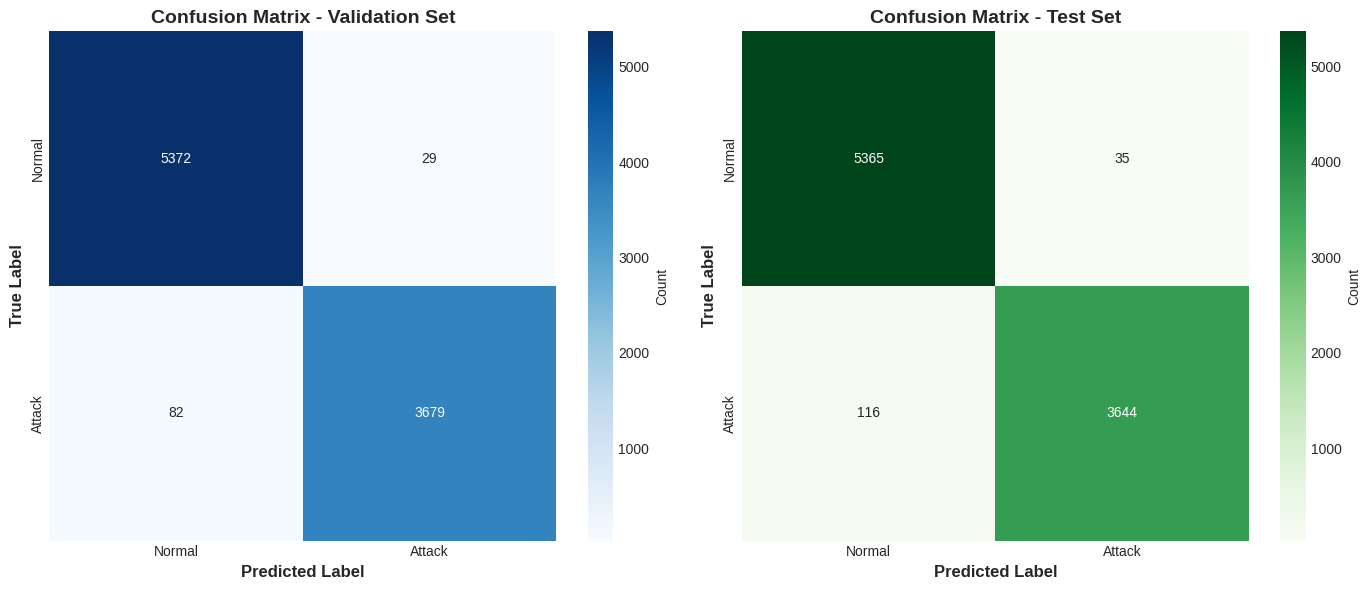

In [34]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
val_cm = confusion_matrix(y_val, val_predictions_optimal)
sns.heatmap(val_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Attack'],
            yticklabels=['Normal', 'Attack'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Validation Set', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')

plt.subplot(1, 2, 2)
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Normal', 'Attack'],
            yticklabels=['Normal', 'Attack'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

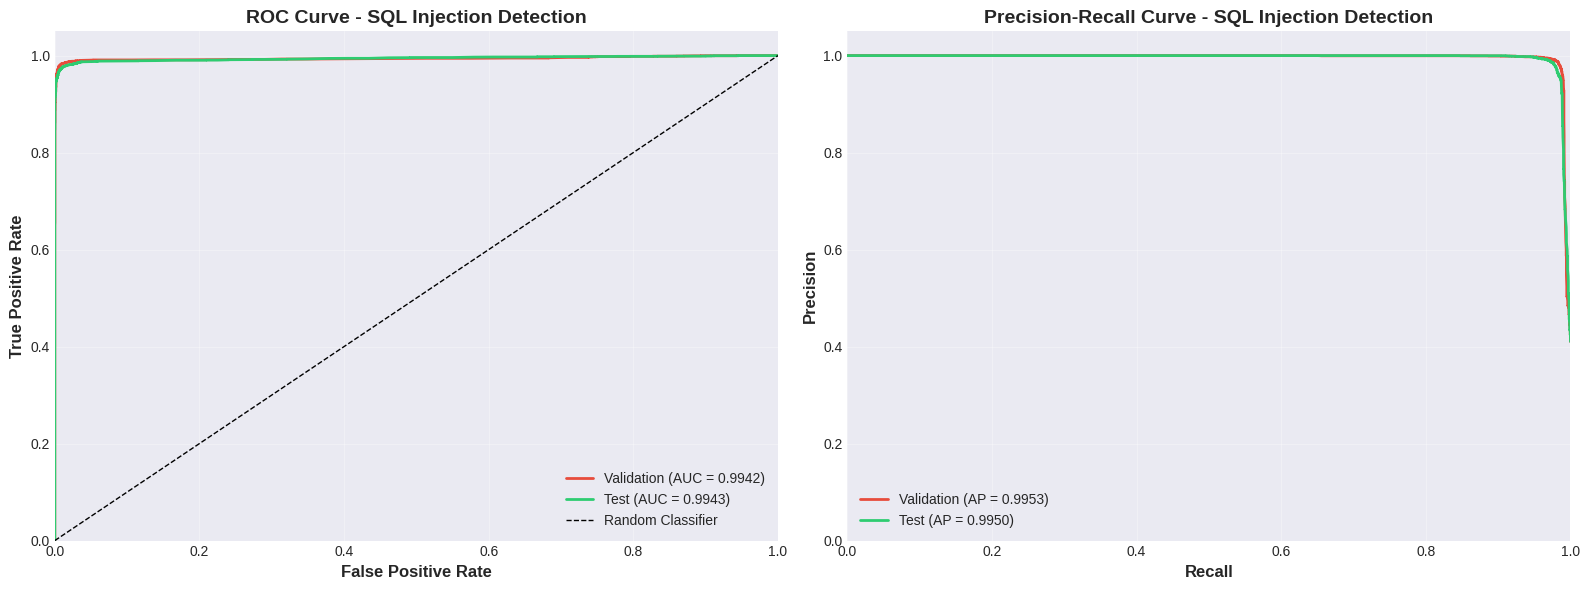

In [35]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
fpr_val, tpr_val, _ = roc_curve(y_val, val_predictions_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, test_predictions_proba)
val_auc = roc_auc_score(y_val, val_predictions_proba)
test_auc = roc_auc_score(y_test, test_predictions_proba)
plt.plot(fpr_val, tpr_val, label=f'Validation (AUC = {val_auc:.4f})', linewidth=2, color='#e74c3c')
plt.plot(fpr_test, tpr_test, label=f'Test (AUC = {test_auc:.4f})', linewidth=2, color='#2ecc71')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('ROC Curve - SQL Injection Detection', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
precision_val, recall_val, _ = precision_recall_curve(y_val, val_predictions_proba)
precision_test, recall_test, _ = precision_recall_curve(y_test, test_predictions_proba)
val_ap = average_precision_score(y_val, val_predictions_proba)
test_ap = average_precision_score(y_test, test_predictions_proba)
plt.plot(recall_val, precision_val, label=f'Validation (AP = {val_ap:.4f})', linewidth=2, color='#e74c3c')
plt.plot(recall_test, precision_test, label=f'Test (AP = {test_ap:.4f})', linewidth=2, color='#2ecc71')
plt.xlabel('Recall', fontsize=12, fontweight='bold')
plt.ylabel('Precision', fontsize=12, fontweight='bold')
plt.title('Precision-Recall Curve - SQL Injection Detection', fontsize=14, fontweight='bold')
plt.legend(loc='lower left', fontsize=10)
plt.grid(alpha=0.3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.tight_layout()
plt.show()

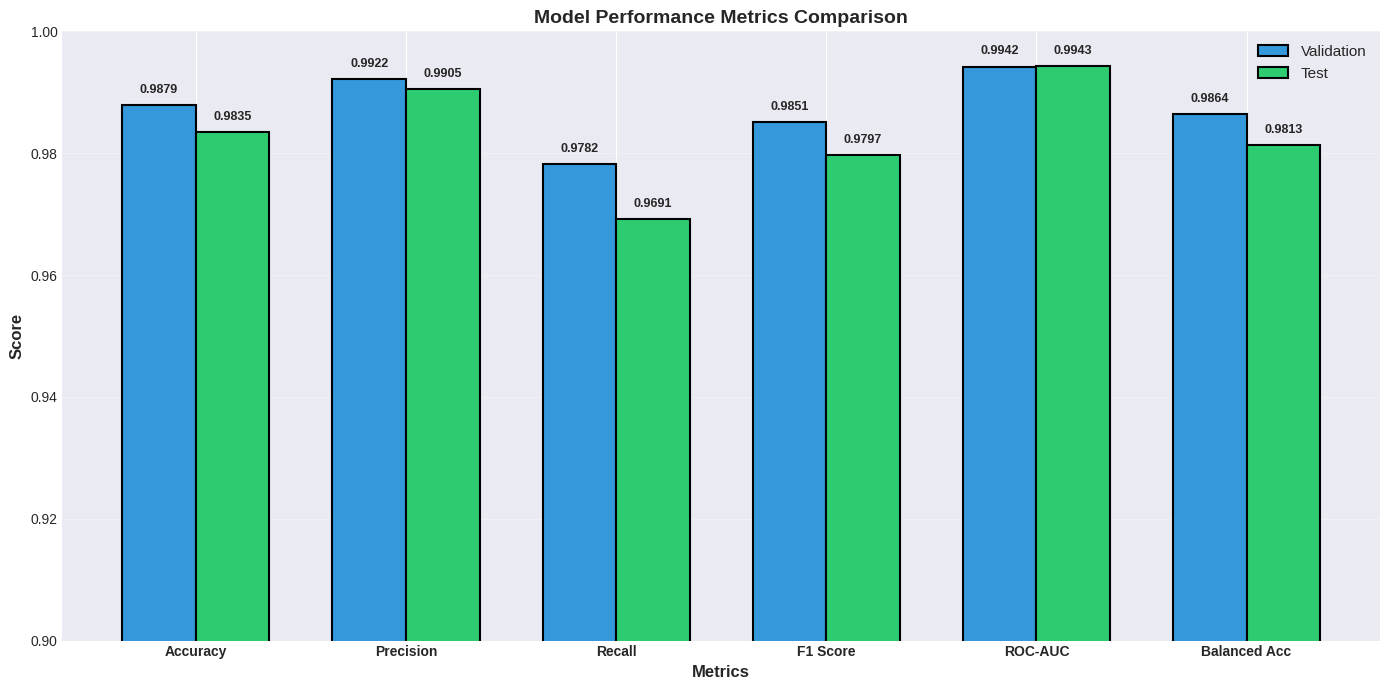

In [36]:
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC', 'Balanced Acc']
val_metrics_values = [val_accuracy_opt, val_precision_opt, val_recall_opt,
                      val_f1_opt, val_roc_auc, val_balanced_acc_opt]
test_metrics_values = [test_accuracy, test_precision, test_recall,
                       test_f1, test_roc_auc, test_balanced_acc]

x = np.arange(len(metrics_names))
width = 0.35

plt.figure(figsize=(14, 7))
plt.bar(x - width/2, val_metrics_values, width, label='Validation',
        color='#3498db', edgecolor='black', linewidth=1.5)
plt.bar(x + width/2, test_metrics_values, width, label='Test',
        color='#2ecc71', edgecolor='black', linewidth=1.5)

plt.xlabel('Metrics', fontsize=12, fontweight='bold')
plt.ylabel('Score', fontsize=12, fontweight='bold')
plt.title('Model Performance Metrics Comparison', fontsize=14, fontweight='bold')
plt.xticks(x, metrics_names, fontweight='bold')
plt.ylim([0.9, 1.0])
plt.legend(fontsize=11)
plt.grid(axis='y', alpha=0.3)

for i, v in enumerate(val_metrics_values):
    plt.text(i - width/2, v + 0.002, f'{v:.4f}', ha='center', fontsize=9, fontweight='bold')
for i, v in enumerate(test_metrics_values):
    plt.text(i + width/2, v + 0.002, f'{v:.4f}', ha='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

In [37]:
best_model.save('csic_sql_injection_transformer_model.keras')
print("Model saved as 'csic_sql_injection_transformer_model.keras'")

val_metrics = {
    'accuracy': float(val_accuracy_opt),
    'precision': float(val_precision_opt),
    'recall': float(val_recall_opt),
    'f1_score': float(val_f1_opt),
    'roc_auc': float(val_roc_auc),
    'balanced_accuracy': float(val_balanced_acc_opt),
    'specificity': float(val_specificity_opt),
    'sensitivity': float(val_sensitivity_opt)
}

test_metrics = {
    'accuracy': float(test_accuracy),
    'precision': float(test_precision),
    'recall': float(test_recall),
    'f1_score': float(test_f1),
    'roc_auc': float(test_roc_auc),
    'avg_precision': float(test_avg_precision),
    'balanced_accuracy': float(test_balanced_acc),
    'specificity': float(test_specificity),
    'sensitivity': float(test_sensitivity)
}

evaluation_results = {
    'validation_metrics': val_metrics,
    'test_metrics': test_metrics,
    'validation_cm': val_cm.tolist(),
    'test_cm': test_cm.tolist(),
    'history': {k: [float(v) for v in vals] for k, vals in history.history.items()}
}
joblib.dump(evaluation_results, 'evaluation_results.pkl')
print("Evaluation results saved as 'evaluation_results.pkl'")

preprocessing_artifacts = {
    'max_words': MAX_WORDS,
    'max_len': MAX_LEN,
    'optimal_threshold': float(optimal_threshold),
    'vocab_size': vocab_size,
    'embed_dim': EMBED_DIM,
    'num_heads': NUM_HEADS,
    'ff_dim': FF_DIM,
    'dropout_rate': DROPOUT_RATE,
    'num_transformer_blocks': NUM_TRANSFORMER_BLOCKS
}
joblib.dump(preprocessing_artifacts, 'preprocessing_artifacts.pkl')
print("Preprocessing artifacts saved as 'preprocessing_artifacts.pkl'")

Model saved as 'csic_sql_injection_transformer_model.keras'
Evaluation results saved as 'evaluation_results.pkl'
Preprocessing artifacts saved as 'preprocessing_artifacts.pkl'


In [38]:
def predict_sql_injection(queries,
                         model_path='csic_sql_injection_transformer_model.keras',
                         tokenizer_path='tokenizer.pkl',
                         config_path='preprocessing_artifacts.pkl'):

    model = tf.keras.models.load_model(model_path, custom_objects={
        'TransformerBlock': TransformerBlock,
        'TokenAndPositionEmbedding': TokenAndPositionEmbedding,
        'f1_metric': f1_metric,
        'balanced_accuracy': balanced_accuracy
    })

    tokenizer = joblib.load(tokenizer_path)
    config = joblib.load(config_path)

    if isinstance(queries, str):
        queries = [queries]

    cleaned_queries = [clean_text(q) for q in queries]

    sequences = tokenizer.texts_to_sequences(cleaned_queries)
    padded = pad_sequences(sequences, maxlen=config['max_len'],
                          padding='post', truncating='post')

    probabilities = model.predict(padded, verbose=0).flatten()
    predictions = (probabilities >= config['optimal_threshold']).astype(int)

    results = []
    for i, query in enumerate(queries):
        results.append({
            'query': query[:150] + '...' if len(query) > 150 else query,
            'prediction': 'Attack' if predictions[i] == 1 else 'Normal',
            'probability': float(probabilities[i]),
            'confidence': float(probabilities[i]) if predictions[i] == 1 else float(1 - probabilities[i]),
            'risk_level': 'High' if probabilities[i] > 0.8 else 'Medium' if probabilities[i] > 0.5 else 'Low'
        })

    return results

In [40]:
test_queries = [
    "GET http://localhost:8080/tienda1/publico/index.jsp HTTP/1.1",
    "GET http://localhost:8080/tienda1/publico/anadir.jsp?id=2&cantidad=' OR '1'='1 HTTP/1.1",
    "POST http://localhost:8080/tienda1/publico/registro.jsp HTTP/1.1 login=admin&password=pass123",
    "GET http://localhost:8080/tienda1/publico/productos.jsp?id=1 UNION SELECT NULL, username, password FROM users-- HTTP/1.1",
    "GET http://localhost:8080/tienda1/publico/buscar.jsp?q=<script>alert('XSS')</script> HTTP/1.1",
    "POST http://localhost:8080/tienda1/publico/login.jsp HTTP/1.1 username=test&password=test123",
    "GET http://localhost:8080/tienda1/publico/ver.jsp?id=5; DROP TABLE products;-- HTTP/1.1",
    "GET http://localhost:8080/tienda1/publico/carrito.jsp?item=producto1&cantidad=2 HTTP/1.1"
]

print("\nTesting with sample HTTP requests:\n")
predictions = predict_sql_injection(test_queries)

for i, pred in enumerate(predictions, 1):
    print(f"Test Case {i}:")
    print(f"Query: {pred['query']}")
    print(f"Prediction: {pred['prediction']}")
    print(f"Probability: {pred['probability']:.4f}")
    print(f"Confidence: {pred['confidence']:.4f}")
    print(f"Risk Level: {pred['risk_level']}")


Testing with sample HTTP requests:

Test Case 1:
Query: GET http://localhost:8080/tienda1/publico/index.jsp HTTP/1.1
Prediction: Normal
Probability: 0.0038
Confidence: 0.9962
Risk Level: Low
Test Case 2:
Query: GET http://localhost:8080/tienda1/publico/anadir.jsp?id=2&cantidad=' OR '1'='1 HTTP/1.1
Prediction: Normal
Probability: 0.0022
Confidence: 0.9978
Risk Level: Low
Test Case 3:
Query: POST http://localhost:8080/tienda1/publico/registro.jsp HTTP/1.1 login=admin&password=pass123
Prediction: Normal
Probability: 0.0008
Confidence: 0.9992
Risk Level: Low
Test Case 4:
Query: GET http://localhost:8080/tienda1/publico/productos.jsp?id=1 UNION SELECT NULL, username, password FROM users-- HTTP/1.1
Prediction: Attack
Probability: 1.0000
Confidence: 1.0000
Risk Level: High
Test Case 5:
Query: GET http://localhost:8080/tienda1/publico/buscar.jsp?q=<script>alert('XSS')</script> HTTP/1.1
Prediction: Attack
Probability: 1.0000
Confidence: 1.0000
Risk Level: High
Test Case 6:
Query: POST http://l